# TaskBot

In [1]:
from typing import Optional, List, Union, Annotated

from datetime import date, datetime
from pydantic import BaseModel, Field

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from langchain_core.runnables.config import RunnableConfig
from langchain_core.tools import tool

from langchain_google_vertexai import ChatVertexAI

from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

from promptgit import Prompt

from utils import object_to_xml

from IPython.display import Markdown, Image, display

In [2]:
system = Prompt.from_text("""You are an executive assistant to {user}. 
Your aim is help user manage his/her tasklist and ensure all task completion on time.
Provide actionable recommendation on next work with reasonable assumptions of workload you don't know.
Do not ask clarification unless absolutely necesary.

Use Markdown to respond with sections:
1. Immediate tasks (due today)
2. Work needed for long-term tasks
3. Additional tasks if time allows

Today is {date}.
The tasks are {tasks}""")

In [3]:
class Task(BaseModel):
    id: Optional[int] = None
    due: date
    description: str
    status: int = 0

class TaskList(BaseModel):
    last_update: datetime = Field(default_factory=datetime.now)
    tasks: List[Task] = Field(default = [])

    def __str__(self):
        return object_to_xml(self.model_dump()['tasks'], 'task')
    
    def add(self, due: date, description: str, status: int = 0):
        if len(self.tasks) > 0:
            id = max([t.id for t in self.tasks]) + 1
        else:
            id = 1
        self.tasks.append(Task(id = id, due = due, description = description, status = status))

In [4]:
l = TaskList()
l.add(date(2024, 10, 22), 'submit chemistry homework')
l.add(date(2024, 10, 23), 'second chapter in chemistry texbook')

In [5]:
class TaskState(BaseModel):
    user: str = None
    tasks: TaskList = None
    messages: Annotated[list, add_messages] = []

In [6]:
@tool
def define_task(due_date: str, description: str):
    """
    Create new task for user
    """
    return Task(due=due_date, description=description) 

tool_node = ToolNode([define_task])

In [7]:
llm = ChatVertexAI(model='gemini-1.5-flash-002').bind_tools([define_task])

def initiate(state: TaskState, config: RunnableConfig):
    return {'messages': [
        SystemMessage(str(system).format(tasks=str(state.tasks), user=state.user, date='Oct 22, 2024')),
        HumanMessage('What are my tasks for today?')]
           }

def chatbot(state: TaskState):
    return {"messages": [llm.invoke(state.messages)]}

def human(state: TaskState):
    pass

def call_tools(state: TaskState):
    last_message = state.messages[-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return 'tools'
    else:
        return 'human'

def quit(state: TaskState):
    if state.messages[-1].content.lower() in ['quit', 'end', 'bye']:
        return END
    else:
        return 'chatbot'

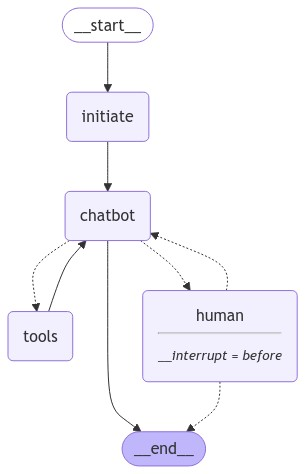

In [8]:
graph_builder = StateGraph(TaskState)

graph_builder.add_node("initiate", initiate)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node("human", human)

graph_builder.add_edge(START, "initiate")
graph_builder.add_edge("initiate", "chatbot")
graph_builder.add_conditional_edges("chatbot", call_tools, ["tools", "human"])
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_conditional_edges("human", quit, ["chatbot", END])
graph_builder.add_edge("chatbot", END)

checkpointer = MemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer, interrupt_before=['human'])

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
config = {"configurable": {"thread_id": "42"}}

In [10]:
response = graph.invoke({'tasks': l}, config)

In [11]:
graph.update_state(config, {'messages':[HumanMessage('one more thing - I have to go to robotics club today')]})

{'configurable': {'thread_id': '42',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef97105-362f-6b74-8005-112f2ee9ea0c'}}

In [12]:
graph.get_state(config).values['messages'][-1]

HumanMessage(content='one more thing - I have to go to robotics club today', additional_kwargs={}, response_metadata={}, id='9871927c-9412-4563-90cb-e6ec955adb95')

In [13]:
for step in graph.get_state_history(config):
    print(step.next)

('human',)
('human',)
('chatbot',)
('tools',)
('chatbot',)
('initiate',)
('__start__',)


In [14]:
response: graph.invoke(None, config)

{'tasks': TaskList(last_update=datetime.datetime(2024, 10, 30, 22, 43, 2, 628993), tasks=[Task(id=1, due=datetime.date(2024, 10, 22), description='submit chemistry homework', status=0), Task(id=2, due=datetime.date(2024, 10, 23), description='second chapter in chemistry texbook', status=0)]),
 'messages': [SystemMessage(content="You are an executive assistant to None. \nYour aim is help user manage his/her tasklist and ensure all task completion on time.\nProvide actionable recommendation on next work with reasonable assumptions of workload you don't know.\nDo not ask clarification unless absolutely necesary.\n\nUse Markdown to respond with sections:\n1. Immediate tasks (due today)\n2. Work needed for long-term tasks\n3. Additional tasks if time allows\n\nToday is Oct 22, 2024.\nThe tasks are <task><item><id>1</id><due>2024-10-22</due><description>submit chemistry homework</description><status>0</status></item><item><id>2</id><due>2024-10-23</due><description>second chapter in chemistr